In [1]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

np.random.seed(42)

C:\Users\Dell\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Dell\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [180]:
data = pd.read_csv("final_data.csv", index_col="dt_iso", parse_dates=True)

In [2]:
def make_lags(df, lags=1):
    
    cols = df.columns
    for col in cols:
        for i in range(lags):
            df[col + "_lag" + str(i + 1)] = df[col].shift(i + 1)
    df = df.dropna()
    
    return df

In [128]:
tensor_data = np.array([
    data["2016"].iloc[1:].drop(["temp"], axis=1).values,
    data["2017"].drop(["temp"], axis=1).values,
    data["2018"].drop(["temp"], axis=1).values
])

target = np.array([
    data["2016"].iloc[1:].temp.values,
    data["2017"].temp.values,
    data["2018"].temp.values
])

tensor_data.shape

(3, 365, 23)

In [129]:
type(tensor_data)

numpy.ndarray

In [130]:
data.shape

(1397, 24)

In [167]:
model = Sequential()
model.add(LSTM(32, activation="tanh", input_shape=(365,23), return_sequences=True))
model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(365))

In [168]:
model.compile(loss="mse", optimizer="rmsprop", metrics=["mse"])

In [169]:
model.fit(tensor_data, target, epochs=20)

Epoch 1/20
3/3 [==============================] - 8s 3s/step - loss: 1.0004 - mean_squared_error: 1.0004
Epoch 2/20
3/3 [==============================] - 1s 286ms/step - loss: 0.9854 - mean_squared_error: 0.9854
Epoch 3/20
3/3 [==============================] - 1s 258ms/step - loss: 0.9559 - mean_squared_error: 0.9559
Epoch 4/20
3/3 [==============================] - 1s 259ms/step - loss: 0.9417 - mean_squared_error: 0.9417
Epoch 5/20
3/3 [==============================] - 1s 268ms/step - loss: 0.9125 - mean_squared_error: 0.9125
Epoch 6/20
3/3 [==============================] - 1s 268ms/step - loss: 0.8652 - mean_squared_error: 0.8652
Epoch 7/20
3/3 [==============================] - 1s 263ms/step - loss: 0.9097 - mean_squared_error: 0.9097
Epoch 8/20
3/3 [==============================] - 1s 263ms/step - loss: 0.9216 - mean_squared_error: 0.9216
Epoch 9/20
3/3 [==============================] - 1s 258ms/step - loss: 0.9287 - mean_squared_error: 0.9287
Epoch 10/20
3/3 [==============

In [170]:
model.evaluate(x=tensor_data[[2]], y=target[[2]])

1/1 [==============================] - 3s 3s/step


[nan, nan]

In [157]:
target[[0]].shape

(1, 365)

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 365, 32)           14208     
_________________________________________________________________
lstm_25 (LSTM)               (None, 3)                 432       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 14,644
Trainable params: 14,644
Non-trainable params: 0
_________________________________________________________________


## Model Training

Data preparation

In [3]:
data = pd.read_csv("data_non_scaled.csv", index_col="dt_iso", parse_dates=True)

In [4]:
scaler_y = StandardScaler(with_mean=True, with_std=True)

scaler_y.fit_transform(data["temp"].values.reshape(-1, 1))

array([[-0.1552767 ],
       [-0.08880289],
       [ 0.14612713],
       ...,
       [ 0.13024752],
       [ 0.01978865],
       [-0.42201004]])

In [5]:
data.shape

(1400, 6)

In [17]:
data = make_lags(data, lags=2)

In [18]:
data.shape

(1396, 30)

In [19]:
scaler = StandardScaler(with_mean=True, with_std=True)

scaled_matr = scaler.fit_transform(data)

In [20]:
train = scaled_matr[:1201, :]
train_index = data.iloc[:1201, :].index
test = scaled_matr[1201:, :]
test_index = data.iloc[1201:, :].index
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 1]
test_X, test_y = test[:, 1:], test[:, 1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1201, 1, 29) (1201,) (195, 1, 29) (195,)


In [21]:
model = Sequential()

model.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(1, train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(Dropout(0.1))
#model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(LSTM(16, activation="relu"))
model.add(Dense(1))

In [22]:
model.compile(loss="mse",
              optimizer="rmsprop",
              metrics=["mae"])

In [23]:
model.fit(train_X, train_y,
          epochs=35)

Epoch 1/35
1201/1201 [==============================] - 3s 3ms/step - loss: 0.9235 - mean_absolute_error: 0.4952
Epoch 2/35
1201/1201 [==============================] - 0s 270us/step - loss: 0.5110 - mean_absolute_error: 0.3445
Epoch 3/35
1201/1201 [==============================] - 0s 251us/step - loss: 0.2798 - mean_absolute_error: 0.2588
Epoch 4/35
1201/1201 [==============================] - 0s 260us/step - loss: 0.2472 - mean_absolute_error: 0.2344
Epoch 5/35
1201/1201 [==============================] - 0s 270us/step - loss: 0.2149 - mean_absolute_error: 0.2144
Epoch 6/35
1201/1201 [==============================] - 0s 259us/step - loss: 0.1910 - mean_absolute_error: 0.2035
Epoch 7/35
1201/1201 [==============================] - 0s 259us/step - loss: 0.1502 - mean_absolute_error: 0.1867
Epoch 8/35
1201/1201 [==============================] - 0s 263us/step - loss: 0.1163 - mean_absolute_error: 0.1721
Epoch 9/35
1201/1201 [==============================] - 0s 262us/step - loss: 0.09

In [24]:
model.evaluate(test_X, test_y)

195/195 [==============================] - 1s 3ms/step


[0.007414238273243731, 0.04776236987553346]

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 64)             24064     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 62,289
Trainable params: 62,289
Non-trainable params: 0
_________________________________________________________________


In [26]:
pred = model.predict(test_X)
pred = scaler_y.inverse_transform(pred)
actual = scaler_y.inverse_transform(test_y)

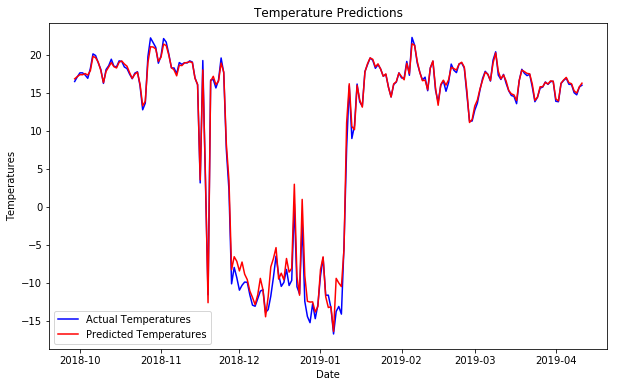

<Figure size 432x288 with 0 Axes>

In [34]:
plt.figure(figsize=(10,6))  
plt.plot(pd.Series(actual, index=test_index), color='blue', label='Actual Temperatures')  
plt.plot(pd.Series(pred.reshape(pred.shape[0],), index=test_index), color='red', label='Predicted Temperatures')  
plt.title('Temperature Predictions')  
plt.xlabel('Date')  
plt.ylabel('Temperatures')  
plt.legend()  
plt.show() 
plt.savefig("fig6.jpg")

In [28]:
model.save("weather_forecast_weights.h5")

In [32]:
abs((actual - pred)).mean()

11.490768082632393